In [1]:
import matplotlib.pyplot as plt
from itertools import product
import numpy as np
from collections import Counter
from sklearn.base import BaseEstimator, RegressorMixin, ClassifierMixin
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
import graphviz
import pydotplus
from sklearn.externals.six import StringIO
import os

from IPython.display import Image

%matplotlib inline

In [11]:
def load_data() :
    '''
    读取训练数据和测试数据,并对label进行转换.
    '''
    data_train = np.loadtxt('data/svm-train.txt')
    data_test = np.loadtxt('data/svm-test.txt')
    x_train , y_train = data_train[ : , 0 : 2] , data_train[ : , 2].reshape(-1 , 1)
    x_test , y_test = data_test[ : , 0 : 2] , data_test[ : , 2].reshape(-1 , 1)
    y_train_label = np.array(list(map(lambda x : 1 if x > 0 else 0 , y_train))).reshape(-1 , 1)
    y_test_label = np.array(list(map(lambda x : 1 if x > 0 else 0 , y_test))).reshape(-1 , 1)
    return x_train , y_train , x_test , y_test , y_train_label , y_test_label

In [3]:
class Decision_Tree(BaseEstimator):
     
    def __init__(self , split_loss_function , leaf_value_estimator ,
                 depth = 0 , min_sample = 5 , max_depth = 10) :
        '''
        决策树初始化,每个Decision_Tree object都代表一棵子树.
        Parameters:
            split_loss_function - 分裂损失函数 , 函数.
            leaf_value_estimator - 节点值计算函数 , 函数.
            depth - 节点深度 , 整数.
            min_sample - 节点允许的最少样本数 , 整数.
            max_depth - 决策树允许的最大深度 , 整数
            is_leaf - 该节点是否为叶子结点 , True / False
            split_id - 该结点采取的分裂特征的标号 , 整数 / None
            split_value - 对应分裂特征的分裂阈值 , 整数 / None
            value - 节点值 , (分类树) label 整数 或者 (回归树) r 实数.
            left - 左子树 , Decision_Tree
            right - 右子树 , Decision_Tree
        '''
        self.split_loss_function = split_loss_function
        self.leaf_value_estimator = leaf_value_estimator
        self.depth = depth
        self.min_sample = min_sample
        self.max_depth = max_depth
        self.is_leaf = None
        self.split_id = None
        self.split_value = None
        self.value = None
        self.left = None
        self.right = None

    def fit(self, X, y=None):
        '''
        根据训练样本实现递归建立决策树,其中使用了预剪枝.枚举所有的特征以及每个特征的取值,根据分裂损失函数计算最优分裂特征以及分裂点.
        Args:
            X - 训练样本输入特征 , 二维numpy数组(num_instances , num_features)
            y - 训练样本label , 二维numpy数组(num_instances , 1)
                                这里y也使用二维数组的好处是方便合并排序
        '''
        
        #达到树的最大深度
        if (self.depth == self.max_depth) :
            self.is_leaf = True
            self.value = self.leaf_value_estimator(y)
            return self
        
        #样本个数少于给定阈值
        if (len(y) <= self.min_sample) :
            self.is_leaf = True
            self.value = self.leaf_value_estimator(y)
            return self
        
        loss_before_split = self.split_loss_function(y)
        best_split_value = None
        best_split_id = None
        best_loss = loss_before_split
        best_left_X = None
        best_left_y = None
        best_right_X = None
        best_right_y = None
        
        X = np.concatenate([X , y] , axis = 1)
        
        for i in range(X.shape[1] - 1) :
            X = np.array(sorted(X , key = lambda x : x[i]))
            for j in range(X.shape[0] - 1) :
                left_X = X[ : j + 1 , : -1]
                left_y = X[ : j + 1 , -1].reshape(-1 , 1)
                right_X = X[j + 1 : , : -1]
                right_y = X[j + 1 : , -1].reshape(-1 , 1)
                left_loss = len(left_y) * self.split_loss_function(left_y) / len(y)
                right_loss = len(right_y) * self.split_loss_function(right_y) / len(y)
                if ((left_loss + right_loss) < best_loss) :
                    best_loss = left_loss + right_loss
                    best_split_value = left_X[j , i]
                    best_split_id = i
                    best_left_X = left_X
                    best_left_y = left_y
                    best_right_X = right_X
                    best_right_y = right_y
        
        if (best_split_id == None) :
            self.is_leaf = True
            self.value = self.leaf_value_estimator(y)
        else :
            self.split_id = best_split_id
            self.split_value = best_split_value
            self.loss = best_loss
            self.left = Decision_Tree(self.split_loss_function , self.leaf_value_estimator , self.depth + 1 ,
                                     self.min_sample , self.max_depth)
            self.right = Decision_Tree(self.split_loss_function , self.leaf_value_estimator , self.depth + 1 ,
                                     self.min_sample , self.max_depth)
            self.left.fit(best_left_X , best_left_y)
            self.right.fit(best_right_X , best_right_y)
            
        return self

    def predict_instance(self, instance):
        '''
        对新样本的值进行预测.根据每一个节点的分裂特征标号split_id和分裂值split_value进行查找,直到叶子节点.
        Args:
            instance - 待预测样本特征 , 一维numpy数组(num_features)
        Returns :
            value - 预测值 , 整数 / 实数(根据决策树类型)
        '''
        if self.is_leaf:
            return self.value
        if instance[self.split_id] <= self.split_value:
            return self.left.predict_instance(instance)
        else:
            return self.right.predict_instance(instance)
        
def compute_entropy(label_array):
    '''
    根据给定label数组计算决策树节点的熵.
    Args:
        label_array - 节点样本的label数组 , 二维numpy数组(num_instances , 1)
    Returns:
        entropy - 熵值
    '''
    label_cnt = Counter(label_array.reshape(len(label_array)))
    entropy = 0.0
    for k , v in label_cnt.items() :
        prob = v * 1.0 / (len(label_array) * 1.0)
        entropy -= prob * np.log(1e-8 + prob)
    return entropy

def compute_gini(label_array):
    '''
    根据给定label数组计算决策树节点的基尼值.
    Args:
        label_array - 节点样本的label数组 , 二维numpy数组(num_instances , 1)
    Returns:
        gini - gini值
    '''
    # Your code goes here
    
    label_cnt = Counter(label_array.reshape(len(label_array)))
    gini = 1.0
    for k , v in label_cnt.items() :
        prob = v * 1.0 / (len(label_array) * 1.0)
        gini -= prob * prob
    return gini

def most_common_label(label_array):
    '''
    对于分类树,返回该节点样本最多的类的标号.
    Args:
        label_array - 节点样本的label数组 , 二维numpy数组(num_instances , 1)
    Returns:
        label - 样本最多的类的标号
    '''
    label_cnt = Counter(label_array.reshape(len(label_array)))
    label = label_cnt.most_common(1)[0][0]
    return label

class Classification_Tree(BaseEstimator , ClassifierMixin):
    ''' 
    分类树类. loss_function_dict为可选的损失函数字典,实现了entropy(熵)和gini(基尼值)两种.
    '''
    loss_function_dict = {
        'entropy': compute_entropy,
        'gini': compute_gini
    }

    def __init__(self , loss_function = 'entropy' , min_sample = 5 , max_depth = 10) :
        '''
        分类树object初始化.
        parameters:
            loss_function - 损失函数类型 , 函数
            min_sample - 节点的最小样本数 , 整数
            max_depth - 分类树的最大深度 , 整数
        '''

        self.tree = Decision_Tree(self.loss_function_dict[loss_function] ,
                                most_common_label ,
                                0 , min_sample , max_depth)

    def fit(self , X , y = None):
        '''
        分类树拟合函数.从根节点开始训练拟合.
        '''
        self.tree.fit(X,y)
        return self

    def predict_instance(self, instance):
        '''
        对新样本的值进行预测.从分类树根节点出发,根据每一个节点的分裂特征标号split_id和分裂值split_value进行查找,直到叶子节点.
        Args:
            instance - 待预测样本特征 , 一维numpy数组(num_features)
        Returns :
            value - 预测值 , 整数 / 实数(根据决策树类型)
        '''
        value = self.tree.predict_instance(instance)
        return value

In [12]:
def Experiment1(x_train , y_train , x_test , y_test , y_train_label , y_test_label) :
    '''
    实验一,实现分类树模型,构建不同深度的分类树对二分类数据进行拟合.绘制图表,观察实验现象,当样本较少,深度较大时,容易出现过拟合现象.
    '''
    clf1 = Classification_Tree(max_depth = 1)
    clf1.fit(x_train, y_train_label)

    clf2 = Classification_Tree(max_depth = 2)
    clf2.fit(x_train, y_train_label)

    clf3 = Classification_Tree(max_depth = 3)
    clf3.fit(x_train, y_train_label)

    clf4 = Classification_Tree(max_depth = 4)
    clf4.fit(x_train, y_train_label)

    clf5 = Classification_Tree(max_depth = 5)
    clf5.fit(x_train, y_train_label)
    
    clf6 = Classification_Tree(max_depth = 6)
    clf6.fit(x_train, y_train_label)

    x_min, x_max = x_train[ : , 0].min() - 1 , x_train[ : , 0].max() + 1
    y_min, y_max = x_train[ : , 1].min() - 1 , x_train[ : , 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min , x_max , 0.1) , np.arange(y_min , y_max , 0.1))

    f, axarr = plt.subplots(2 , 3 , sharex = 'col' , sharey = 'row' , figsize = (10, 8))

    for idx, clf, tt in zip(product([0 , 1] , [0 , 1 , 2]),
                        [clf1 , clf2 , clf3 , clf4 , clf5 , clf6],
                        ['Depth = {}'.format(n) for n in range(1 , 7)]):

        Z = np.array([clf.predict_instance(x) for x in np.c_[xx.ravel() , yy.ravel()]])
        Z = Z.reshape(xx.shape)
    

        axarr[idx[0] , idx[1]].contourf(xx , yy , Z , alpha = 0.4)
        axarr[idx[0] , idx[1]].scatter(x_train[ : , 0] , x_train[ : , 1] , c=y_train_label.reshape(len(y_train_label)) 
                                       , alpha = 0.8)
    axarr[idx[0] , idx[1]].set_title(tt)

    plt.show()

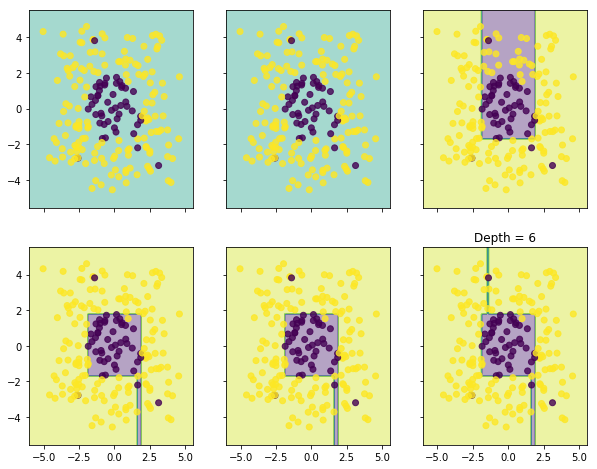

In [13]:
x_train , y_train , x_test , y_test , y_train_label , y_test_label = load_data()
Experiment1(x_train , y_train , x_test , y_test , y_train_label , y_test_label)

In [16]:
def Experiment2(x_train , y_train , x_test , y_test , y_train_label , y_test_label) :
    '''
    实验二,对sklearn包的二分类树,进行训练拟合,并利用Graphviz进行分类树的节点可视化工作.
    '''
    clf = DecisionTreeClassifier(criterion = 'entropy' , max_depth = 2 , min_samples_split = 5)
    clf.fit(x_train , y_train_label)
    export_graphviz(clf , out_file = 'tree_classifier.dot')
    !dot -Tpng tree_classifier.dot -o tree_classifier.png

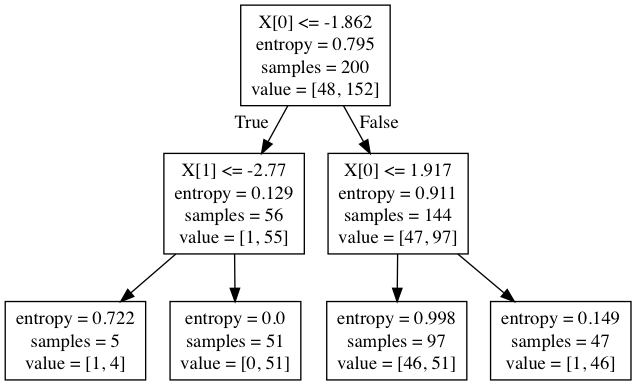

In [18]:
Experiment2(x_train , y_train , x_test , y_test , y_train_label , y_test_label)
Image(filename='tree_classifier.png')